In [19]:
import os
import re
import numpy as np
import pickle
from IPython.display import display, Latex

In [20]:
def filename_to_phi_gamma_tuple(file_name):
    # Search for the pattern in the filename
    pattern = r"phi_([0-9.]+)pi_gamma_([0-9.]+)"
    match = re.search(pattern, file_name)

    if match:
        phi_value = float(match.group(1)) * np.pi  # Append 'pi' to the phi value

        gamma_value = float(match.group(2)[:-1])
    else:
        print("No match found")
    
    return (phi_value, gamma_value)

In [21]:
def find_first_exceeding_index(values, single_value):
    """
    Find the index of the first element in values that exceeds single_value.

    Parameters:
    - values: A list of numerical values.
    - single_value: The single numerical value to compare against.

    Returns:
    - The index of the first element in values that exceeds single_value,
      or -1 if no such element is found.
    """
    for index, value in enumerate(values):
        if value > single_value:
            return index
    return -1  # Indicates no value was found that exceeds the single value

In [22]:
baseline_gate_fidelities = {
    (0.7853981633974483, 0.01): 0.9999938315170672,
    (0.7853981633974483, 0.025): 0.9999614476319376,
    (0.7853981633974483, 0.05): 0.9998457998168983,
    (1.5707963267948966, 0.01): 0.999975326306082,
    (1.5707963267948966, 0.025): 0.9998457998168983,
    (1.5707963267948966, 0.05): 0.999383347869602,
    (2.356194490192345, 0.01): 0.9999444850804711,
    (2.356194490192345, 0.025): 0.9996530844192801,
    (2.356194490192345, 0.05): 0.998613089769379,
    (3.141592653589793, 0.01): 0.9999013090292375,
    (3.141592653589793, 0.025): 0.999383347869602,
    (3.141592653589793, 0.05): 0.9975357675527649
}

In [23]:
def get_time_when_exceed_value(num_update_exceeded, num_update, runtime):
    return round(
            np.ceil(num_update_exceeded / num_update * runtime) / 60, 
            2
    )

In [24]:
target_fidelities = [1.0-infid for infid in [1e-3, 1-5]]
target_fidelities

[0.999, 0.9999]

In [25]:
def plot_summary(phi_gamma_tuple, training_results, target_fidelities):
    
    (phi, gamma) = phi_gamma_tuple
    baseline_gate_fidelity_data = training_results['baseline_gate_fidelity_data']

    latex_output = f"""
        \\textbf{{Baseline Gate Fidelity Data}}:\\
        - $\\varphi$: {phi/np.pi}\\pi; $\\gamma$: {gamma}; \\
        - Baseline Gate Fidelity: {baseline_gate_fidelity_data["baseline_gate_fidelity"]}; \\
        - Number of Updates Before Exceeding Baseline: {baseline_gate_fidelity_data["num_update_basefid_exceeded"]}; \\
        - Total Shots Before Exceeding Baseline: {baseline_gate_fidelity_data["total_shots_before_exceeding_baseline"]:,}; \\
        - Training Time Elapsed Before Exceeding Baseline (mins): {baseline_gate_fidelity_data["training_time_elapsed_before_exceeding_baseline_fid"]};
    """

    latex_output += "\\textbf{Target Fidelity Results}:\\"
    for target_fid in target_fidelities:
        results = training_results[f'abs_target_fidelity_{target_fid}_results']
        latex_output += f"""
        - Target Fidelity: {results['target_fidelity']}; \\
        - Number of Updates Before Exceeding Target: {results['num_update_targetfid_exceeded']}; \\
        - Total Shots Before Exceeding Target: {results['total_shots_before_exceeding_target']:,}; \\
        - Training Time Elapsed Before Exceeding Target (mins): {results['training_time_elapsed_before_exceeding_target_fid']};
        """

    # Display the formatted LaTeX output
    display(Latex(latex_output))


In [26]:
def analyse_results(training_results, file_name, fidelity_results, target_fidelities):
    (phi, gamma) = filename_to_phi_gamma_tuple(file_name)

    # Save the training result for each (phi, gamma) pair
    baseline_gate_fidelity_data = {}
    baseline_gate_fidelity_data['baseline_gate_fidelity'] = baseline_gate_fidelities[(phi, gamma)]
    baseline_gate_fidelity_data['num_update_basefid_exceeded'] = find_first_exceeding_index(training_results['fidelity_history'], baseline_gate_fidelity_data['baseline_gate_fidelity'])
    baseline_gate_fidelity_data['total_shots_before_exceeding_baseline'] = np.cumsum(training_results['total_shots'])[baseline_gate_fidelity_data['num_update_basefid_exceeded']]
    baseline_gate_fidelity_data['training_time_elapsed_before_exceeding_baseline_fid'] = get_time_when_exceed_value(baseline_gate_fidelity_data['num_update_basefid_exceeded'], len(training_results['fidelity_history']), training_results['runtime'])
    training_results['baseline_gate_fidelity_data'] = baseline_gate_fidelity_data

    # Investigate when exceeded the target fidelity
    for target_fid in target_fidelities:
        abs_target_fidelity_results = {}
        abs_target_fidelity_results['target_fidelity'] = target_fid
        abs_target_fidelity_results['num_update_targetfid_exceeded'] = find_first_exceeding_index(training_results['fidelity_history'], target_fid)
        abs_target_fidelity_results['total_shots_before_exceeding_target'] = np.cumsum(training_results['total_shots'])[abs_target_fidelity_results['num_update_targetfid_exceeded']]
        abs_target_fidelity_results['training_time_elapsed_before_exceeding_target_fid'] = get_time_when_exceed_value(abs_target_fidelity_results['num_update_targetfid_exceeded'], len(training_results['fidelity_history']), training_results['runtime'])
        training_results[f'abs_target_fidelity_{target_fid}_results'] = abs_target_fidelity_results

    fidelity_results[(phi, gamma)] = training_results

    best_action_vector = training_results['best_action_vector']

    plot_summary((phi, gamma), training_results, target_fidelities)
    

In [27]:
# Combine all training results into a single dictionary
fidelity_results = {}

In [28]:
# Loop over all files in the current directory
for filename in os.listdir('.'):
    # Check if the file is a .pickle file
    if filename.startswith('training_results') and filename.endswith('.pickle'):
        # Construct the full file path
        filepath = os.path.join('.', filename)
        file_name = os.path.basename(filepath)
        # Load the contents of the .pickle file
        with open(filepath, 'rb') as file:
            training_results = pickle.load(file)

        analyse_results(training_results, file_name, fidelity_results, target_fidelities)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Plot training results in comparison to their baseline

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


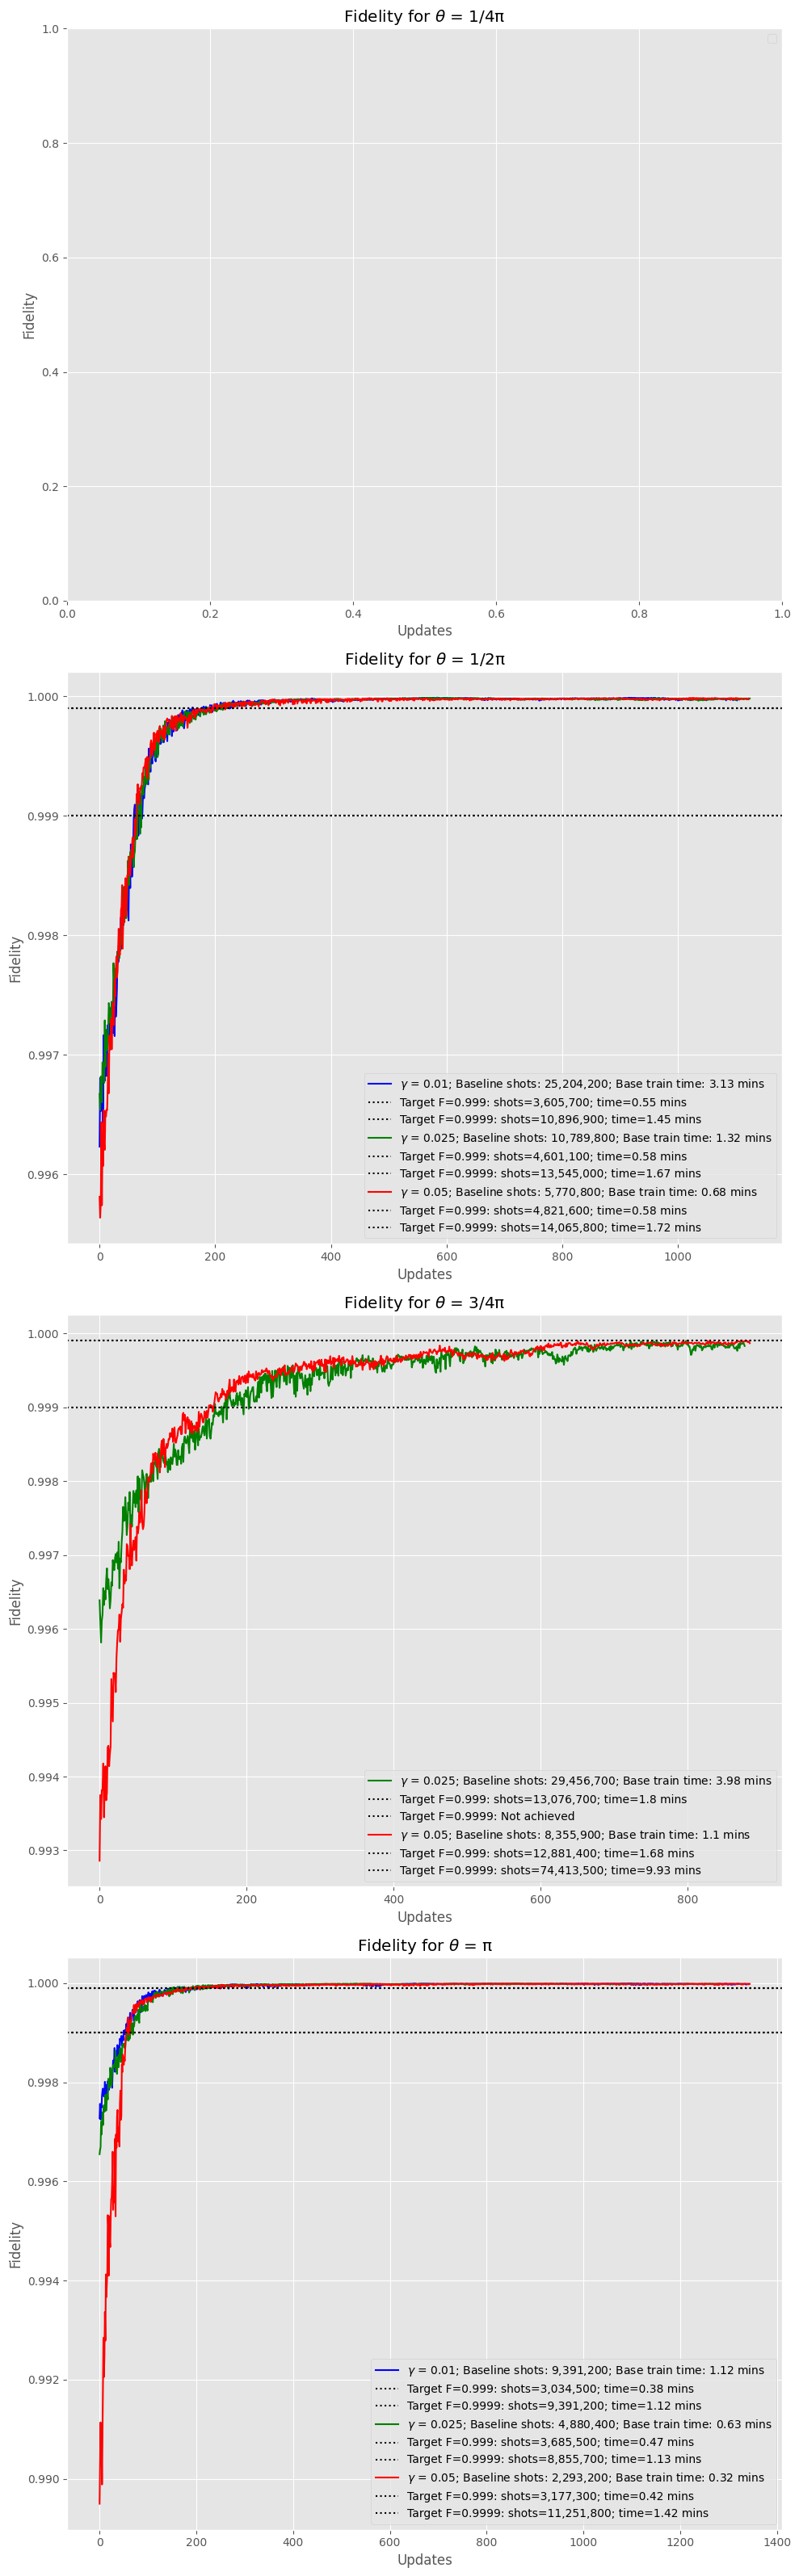

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from fractions import Fraction

# Set the style
plt.style.use('ggplot')

# Define colors for different gamma values for clarity in plotting
gamma_colors = {0.01: 'blue', 0.025: 'green', 0.05: 'red'}

# Assuming fidelity_results is populated as described
# Unique thetas for plotting
unique_thetas = np.pi * np.array([0.25, 0.5, 0.75, 1.0])

# Plot fidelity results
fig, axs = plt.subplots(len(unique_thetas), figsize=(10, 8 * len(unique_thetas)), squeeze=False)
axs = axs.flatten()

for idx, theta in enumerate(unique_thetas):
    plotted_labels = set()  # Using a set to track which labels have been plotted

    for gamma, color in gamma_colors.items():
        if (theta, gamma) in fidelity_results:
            training_results = fidelity_results[(theta, gamma)]

            # Plot the training results for this gamma in its color
            baseline_fidelity = training_results['baseline_gate_fidelity_data']['baseline_gate_fidelity']
            num_update_basefid_exceeded = training_results['baseline_gate_fidelity_data']['num_update_basefid_exceeded']
            total_shots_basefid = training_results['baseline_gate_fidelity_data']['total_shots_before_exceeding_baseline']
            training_time_basefid = training_results['baseline_gate_fidelity_data']['training_time_elapsed_before_exceeding_baseline_fid']

            label_baseline = f'$\gamma$ = {gamma}; Baseline shots: {total_shots_basefid:,}; Base train time: {training_time_basefid} mins'
            if label_baseline not in plotted_labels:
                axs[idx].plot(training_results['fidelity_history'], color=color, label=label_baseline)
                plotted_labels.add(label_baseline)

            # Horizontal line for baseline fidelity
            # axs[idx].axhline(y=baseline_fidelity, color=color, linestyle='dashed',
            #                  label='Baseline fidelity' if 'Baseline fidelity' not in plotted_labels else None)
            # plotted_labels.add('Baseline fidelity')

            for target_fid in target_fidelities:
                target_fid_results = training_results.get(f'abs_target_fidelity_{target_fid}_results')
                if target_fid_results:
                    num_update_targetfid_exceeded = target_fid_results['num_update_targetfid_exceeded']
                    total_shots_targetfid = target_fid_results['total_shots_before_exceeding_target']
                    training_time_targetfid = target_fid_results['training_time_elapsed_before_exceeding_target_fid']

                    label_target = f'Target F={target_fid}: ' 
                    label_target += f'shots={total_shots_targetfid:,}; time={training_time_targetfid} mins' if total_shots_targetfid != np.cumsum(training_results['total_shots'])[-1] else 'Not achieved'
                    if label_target not in plotted_labels:
                        axs[idx].axhline(y=target_fid, color='black', linestyle=':', label=label_target)
                        # if num_update_targetfid_exceeded is not None and num_update_targetfid_exceeded < len(training_results['fidelity_history']):
                        #     label_target += f'Exceeded (fid, updates, mins): ({target_fid}, {num_update_targetfid_exceeded}, {training_time_targetfid})' 
                        plotted_labels.add(label_target)

    # Setting titles and labels
    theta_fraction = Fraction(theta / np.pi).limit_denominator()
    title = f'$\\theta$ = {theta_fraction.numerator}/{theta_fraction.denominator}π' if theta_fraction.denominator > 1 else f'$\\theta$ = π'
    axs[idx].set_title(f'Fidelity for {title}')
    axs[idx].set_xlabel('Updates')
    axs[idx].set_ylabel('Fidelity')
    axs[idx].legend()

plt.tight_layout()
plt.show()